# Attack Attemp 1

First attempt at training the GAN D/G to provide **valid** and **representable** data from unknown classes

## Imports

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
import keras.backend as K
from keras.datasets import mnist

print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params (MUST MATCH Blackbox Evaluator PARAMS)
num_classes = 1
max_epochs = 25
save_every = 1
discriminator_epochs = 25

# Black-box params (optimized for MNIST)
best_depth = 9
best_filters = 33
best_dense = 110

# GAN params
gan_epochs = 1
gan_batch_size = 256 # 60
noise_dim = 100

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

## Build Model

In [5]:
# def start_piece(input_layer, filters=4):
#     assert filters >= 1
    
#     h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(input_layer)
    
#     return h

# def blackbox_piece(h, depth=1, filters=4):
#     assert depth >= 1
#     assert filters >= 1
    
#     # for now, we will just give the black-box all the CNN layers
#     for i in range(depth-1):
#         h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(h)
    
#     return h

# def approximator_piece(h, depth=1, filters=4):
#     assert depth >= 1
#     assert filters >= 1
    
#     # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
#     h = blackbox_piece(h, depth, filters)
    
#     return h

# def end_piece(h, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = MaxPooling2D(pool_size=(2, 2))(h)
#     h = Dropout(0.25)(h, training=training)
#     h = Flatten()(h)
#     h = Dense(dense_breadth, activation='relu')(h)
#     h = Dropout(0.5)(h, training=training)
#     output_layer = Dense(num_classes, activation='softmax')(h)
    
#     return output_layer

In [6]:
# def split_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = start_piece(input_layer, filters)
#     h = blackbox_piece(h, depth, filters)
#     output_layer = end_piece(h, dense_breadth, training)
    
#     return output_layer

# def discriminator_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
#     assert depth >= 1
#     assert filters >= 1
#     assert dense_breadth >= num_classes
    
#     h = start_piece(input_layer, filters)
#     h = approximator_piece(h, depth, filters)
#     output_layer = end_piece(h, dense_breadth, training)
    
#     return output_layer

# def generator_model(input_layer, training=True):
#     h = Dense(7*7*256, use_bias=False, input_shape=(100,))(input_layer)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
#     h = Reshape((7, 7, 256))(h)
    
#     h = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(h)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
    
#     h = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(h)
#     h = BatchNormalization(training=training)(h)
#     h = LeakyReLU()(h)
    
#     output_layer = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(h)
    
#     return output_layer
    
# #     model = tf.keras.Sequential()
# #     model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Reshape((7, 7, 256)))
# #     assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

# #     model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
# #     assert model.output_shape == (None, 7, 7, 128)
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
# #     assert model.output_shape == (None, 14, 14, 64)
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())

# #     model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
# #     assert model.output_shape == (None, 28, 28, 1)

In [7]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece_(input_shape, filters=4):
    assert filters >= 1
    
    model = tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    return model

def blackbox_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
    
    return model

def approximator_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
    model = blackbox_piece_(model, depth, filters)
    
    return model

def end_piece_(model, dense_breadth=128):
    assert dense_breadth >= num_classes
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense_breadth, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Graph Creation

In [8]:
class GAN:
    
    def __init__(self, input_shape, depth, filters, dense, batch_size, noise_dim=100):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        self.batch_size = batch_size
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.discriminator = self.discriminator_model(input_shape, depth, filters, dense)
        self.generator = self.generator_model(noise_dim)
        
        # define loss function (TODO: change to MSE)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        # define optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # seed for image generation
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        
    def train(self, dataset):
        for image_batch in dataset:
            self.train_step(image_batch)
            
    def generate_and_save_images(self):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = self.generator(self.seed, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.show()
        
    def discriminator_model(self, input_shape, depth=1, filters=4, dense_breadth=128):
        assert depth >= 1
        assert filters >= 1
        assert dense_breadth >= num_classes

        model = start_piece_(input_shape, filters)
        model = approximator_piece_(model, depth, filters)
        model = end_piece_(model, dense_breadth)

        return model
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_model(self, noise_dim=100):
        model = tf.keras.Sequential()
        
        model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        return model
    
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

In [9]:
# class SplitLearning:
    
#     def __init__(self, input_shape, depth, filters, dense, batch_size, noise_dim=100):
#         self.input_shape = input_shape
#         self.depth = depth
#         self.filters = filters
#         self.dense = dense
#         self.noise_dim = noise_dim
#         self.batch_size = batch_size
        
#         # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
#         self.split = self.split_model(input_shape, depth, filters, dense)
        
#         # define loss function
#         self.loss = tf.keras.losses.CategoricalCrossEntropy(from_logits=True)
        
#         # define optimizers
#         self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
#         # create training ops
#         self.split_learning_ops()
        
#     def split_model(input_shape, depth=1, filters=4, dense_breadth=128):
#         assert depth >= 1
#         assert filters >= 1
#         assert dense_breadth >= num_classes

#         h = start_piece_(input_shape, filters)
#         h = blackbox_piece_(h, depth, filters)
#         output_layer = end_piece_(h, dense_breadth)

#         return output_layer
    
#     def mse_loss(self, )
        
#     def split_learning_ops(self):
#         # INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

#         # Fetch a list of our network's trainable parameters.
#         self.trainable_vars = split.trainable_variables

#         # Create variables to store accumulated gradients
#         self.accumulators = [
#             tf.Variable(
#                 tf.zeros_like(tv.initialized_value()),
#                 trainable=False
#             ) for tv in self.trainable_vars
#         ]

#         # Create a variable for counting the number of accumulations
#         self.accumulation_counter = tf.Variable(0.0, trainable=False)

#         # Compute gradients; grad_pairs contains (gradient, variable) pairs
#         self.grad_pairs = self.optimizer.compute_gradients(self.loss, self.trainable_vars)

#         # Create operations which add a variable's gradient to its accumulator.
#         self.accumulate_ops = [
#             accumulator.assign_add(
#                 grad
#             ) for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)
#         ]

#         # The final accumulation operation is to increment the counter
#         self.accumulate_ops.append(self.accumulation_counter.assign_add(1.0))

#         # Update trainable variables by applying the accumulated gradients
#         # divided by the counter. Note: apply_gradients takes in a list of 
#         # (grad, var) pairs
#         self.train_step = self.optimizer.apply_gradients(
#             [(accumulator / self.accumulation_counter, var) \
#                 for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
#         )

#         # Accumulators must be zeroed once the accumulated gradient is applied.
#         self.zero_ops = [
#             accumulator.assign(
#                 tf.zeros_like(tv)
#             ) for (accumulator, tv) in zip(self.accumulators, self.trainable_vars)
#         ]

#         # Add one last op for zeroing the counter
#         self.zero_ops.append(self.accumulation_counter.assign(0.0))
        
#     @tf.function
#     def zero_step(self):
#         return self.zero_ops
        
#     @tf.function
#     def accum_step(self, images):
#         split_loss = self.mse_loss(images)
#         return self.accumulate_ops
        
#     @tf.function
#     def train_step(self, images):
        
#         self.optimizer.apply_gradients(
#             [(accumulator / self.accumulation_counter, var) \
#                 for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
#         )

In [10]:
class SplitLearningGAN:
    
    def __init__(self, input_shape, depth, filters, dense, noise_dim,
                 gan_batch_size, gan_epochs):#, split_epochs, attack_epochs):
        self.input_shape = input_shape
        self.depth = depth
        self.filters = filters
        self.dense = dense
        self.noise_dim = noise_dim
        
        self.gan_epochs = gan_epochs
#         self.split_epochs = split_epochs
#         self.attack_epochs = attack_epochs
        
        self.gan = GAN(input_shape, depth, filters, dense, gan_batch_size, noise_dim)
        
    def train_system(self, dataset):
        
        # train GAN first:
        for e in tqdm_notebook(range(self.gan_epochs)):
            self.gan.train(dataset)

In [11]:
# Testing with a dataset we know works...

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(gan_batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
slg = SplitLearningGAN(input_shape, best_depth, best_filters, best_dense, noise_dim, gan_batch_size, gan_epochs)
slg.train_system(train_dataset)

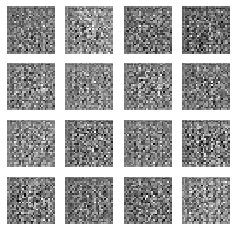

In [13]:
slg.gan.generate_and_save_images()